In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

In [2]:
train_data = pd.read_csv("handout/train_features.csv", delimiter=",")
train_labels = pd.read_csv("handout/train_labels.csv", delimiter=",")
test_data = pd.read_csv("handout/test_features.csv", delimiter=",")

train_data = train_data.sort_values(['pid','Time'])
train_labels = train_labels.sort_values(['pid'])
test_data = test_data.sort_values(['pid','Time'])

In [3]:
# new feature that keeps track of wheter or not a certain feature was present
for col in train_data.columns[3:]:
    train_data[f"{col}_notna"] = train_data[col].notna().astype(int)

for col in test_data.columns[3:]:
    test_data[f"{col}_notna"] = test_data[col].notna().astype(int)

In [4]:
# substitute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
imputer.fit(train_data)
train_data_implaced = imputer.transform(train_data)
train_data_implaced = pd.DataFrame(train_data_implaced, columns=train_data.columns)

imputer = SimpleImputer(strategy='mean')
imputer.fit(test_data)
test_data_implaced = imputer.transform(test_data)
test_data_implaced = pd.DataFrame(test_data_implaced, columns=test_data.columns)

In [5]:
# normalize
for col in train_data_implaced.columns[2:]:
    train_data_implaced[col] = (train_data_implaced[col] - train_data_implaced[col].min()) / (train_data_implaced[col].max() - train_data_implaced[col].min())

for col in test_data_implaced.columns[2:]:
    test_data_implaced[col] = (test_data_implaced[col] - test_data_implaced[col].min()) / (test_data_implaced[col].max() - test_data_implaced[col].min())

In [6]:
# same values for time
train_data_implaced["Time"] = list(range(1, 13)) * len(list(set(train_data_implaced["pid"])))
test_data_implaced["Time"] = list(range(1, 13)) * len(list(set(test_data_implaced["pid"])))

In [7]:
# pivot
train_data_pivoted = train_data_implaced.pivot(index="pid", columns="Time", values=train_data_implaced.columns[2:])
test_data_pivoted = test_data_implaced.pivot(index="pid", columns="Time", values=test_data_implaced.columns[2:])

In [8]:
train_labels = train_labels.set_index("pid")
train_labels = train_labels.sort_index()

In [9]:
#labels = ['BaseExcess', 'Fibrinogen', 'AST', 'Alkalinephos', 'Bilirubin_total', 'Lactate', 'TroponinI', 'SaO2', 'Bilirubin_direct', 'EtCO2']
# only to test
labels = ["BaseExcess"]
labels = [f"LABEL_{label}" for label in labels]

In [10]:
def balance_dataset(train_data, train_labels, label):
    train_data_0 = train_data[train_labels[label] == 0]
    train_data_1 = train_data[train_labels[label] == 1]

    n = min(train_data_0.shape[0], train_data_1.shape[0])
    train_data_ok = pd.concat([train_data_0.sample(n), train_data_1.sample(n)])
    train_data_ok = shuffle(train_data_ok)
    
    train_labels_ok = train_labels.loc[train_data_ok.index, label]

    return train_data_ok, train_labels_ok

LABEL_BaseExcess
ROC AUC: 0.9149049460410873


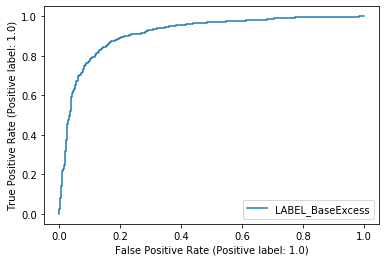

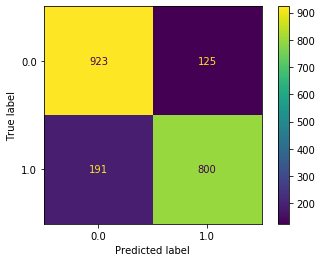

In [12]:
for label in labels:
    train_data_balanced, train_labels_balanced = balance_dataset(train_data_pivoted, train_labels, label)
    X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, train_labels_balanced, test_size=0.2, random_state=42)
    
    #weights = X_train["svc_weights"]
    #X_train = X_train.drop(columns=["svc_weights"])
    #X_test = X_test.drop(columns=["svc_weights"])

    clf = svm.SVC(probability=True)
    #clf.fit(X_train, y_train, sample_weight=weights)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Evaluation
    print(label)
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")
    plot_roc_curve(clf, X_test, y_test, label=label)
    plot_confusion_matrix(clf, X_test, y_test)